## LC Model Search Framework Scikit-Learn

* Compare 1 season (summer) and 4 temporal steps
* Compare 0 - 1500 training training samples per class in 100 sample increments
* CNN component and RNN components in isolation
* regular CNN+RNN vs conv2dlstm and RNN vs just conv2dLSTM
* Compare to scikit-learn methods using same val and test datasets
* Compare best model across time
    * if major decrease in accuracy then consider training on both 2010 and 2011 data for initial time step
        * consider training on 1999 data to see how it changes the model

In [1]:
import comet_ml
from comet_ml import Experiment
import datetime
import rasterio
import keras
import pandas as pd
import seaborn as sns
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [31]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

In [3]:
exp_name = 'quick_view_all_onestep'
model_name = 'all_sklearn'

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [4]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [5]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

### Load pixels from shapefiles

In [6]:
train_gdf = gpd.read_file('../train_buffered_points140520.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((3133, 4332), '028011'))

In [7]:
val_gdf = gpd.read_file('../test_buffered_points140520_val.shp')
val_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['dubious']:
        total_per_class_count[int(row['label'])] = total_per_class_count[int(row['label'])] + 1
        if per_class_count[int(row['label'])] < 125:
            per_class_count[int(row['label'])] = per_class_count[int(row['label'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(750, ((3845.0, 3985.0), '028011'))

In [8]:
total_per_class_count, per_class_count

([141, 147, 133, 133, 130, 129], [125, 125, 125, 125, 125, 125])

In [9]:
val_gdf.head()

,canopy,col,label,row,tile_name,x,y,manual_val,dubious,reject,geometry
0,0.0,3884.0,0.0,1617.0,028012,1750950.0,1466280.0,0,0,0,POLYGON ((-76.61112678048431 34.64445257944547...
1,0.0,4553.0,0.0,693.0,028011,1771020.0,1644000.0,0,0,0,POLYGON ((-75.98675821109941 36.16139632039837...
2,0.0,1140.0,0.0,1835.0,029011,1818630.0,1609740.0,0,0,0,POLYGON ((-75.54709982307929 35.77251818591635...
3,0.0,3023.0,0.0,3896.0,028011,1725120.0,1547910.0,0,0,0,POLYGON ((-76.70836461104372 35.40562568571118...
4,0.0,989.0,0.0,3414.0,028012,1664100.0,1412370.0,0,0,0,POLYGON ((-77.66217912565303 34.32496740952818...


Start the experiments here:

In [10]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: old comet version (3.1.6) detected. current: 3.1.7 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/a2997fff4fba4a33bae60f97c7cc53ea



In [11]:
experiment.add_tag(exp_name)

In [12]:
tile_size = 13
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 0
batch_size = 0
steps_division_factor = 0

retrieve data and reshape into sklearn format

train data

In [13]:
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

train_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True)
lc_lab = np.empty(len(train_px))
count = 0
img_list = []
while count < len(train_px):
        image_b, label_b = next(train_generator)
        img_list.append(image_b['tile_input'])
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        lc_lab[count] = label_lc
        count += 1

In [14]:
sk_images = np.array(img_list).reshape(9000,-1)

validation data

In [15]:
val_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)
val_lc_lab = np.empty(len(val_px))
count = 0
val_img_list = []
while count < len(val_px):
        image_b, label_b = next(val_generator)
        val_img_list.append(image_b['tile_input'])
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        val_lc_lab[count] = label_lc
        count += 1


In [16]:
val_sk_images = np.array(val_img_list).reshape(750,-1)

In [17]:
from sklearn import neighbors, datasets

n_neighbors = 50

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
train_time_start = datetime.datetime.now()
clf.fit(sk_images, lc_lab)

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start
print(training_time)
clf.score(val_sk_images, val_lc_lab)

0:00:02.493430


0.908

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
clf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
train_time_start = datetime.datetime.now()

clf.fit(sk_images, lc_lab)

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start
print(training_time)
clf.score(val_sk_images, val_lc_lab)

0:04:44.043562


0.972

In [19]:
# from sklearn import svm
# clf = svm.SVC(gamma='scale')

# train_time_start = datetime.datetime.now()

# clf.fit(sk_images, lc_lab)

# train_time_stop = datetime.datetime.now()
# training_time = train_time_stop - train_time_start
# print(training_time)
# clf.score(val_sk_images, val_lc_lab)

In [20]:
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()


# train_time_start = datetime.datetime.now()

# clf.fit(sk_images, lc_lab)

# train_time_stop = datetime.datetime.now()
# training_time = train_time_stop - train_time_start
# print(training_time)
# clf.score(val_sk_images, val_lc_lab)

# Evaluate model

In [21]:
inference_time_start = datetime.datetime.now()

pred_index = clf.predict(val_sk_images)
#clf.score(val_sk_images, val_lc_lab)

inference_time_stop = datetime.datetime.now()
inference_time = inference_time_stop - inference_time_start
print(inference_time)

0:00:00.156127


Accuracy is 0.972


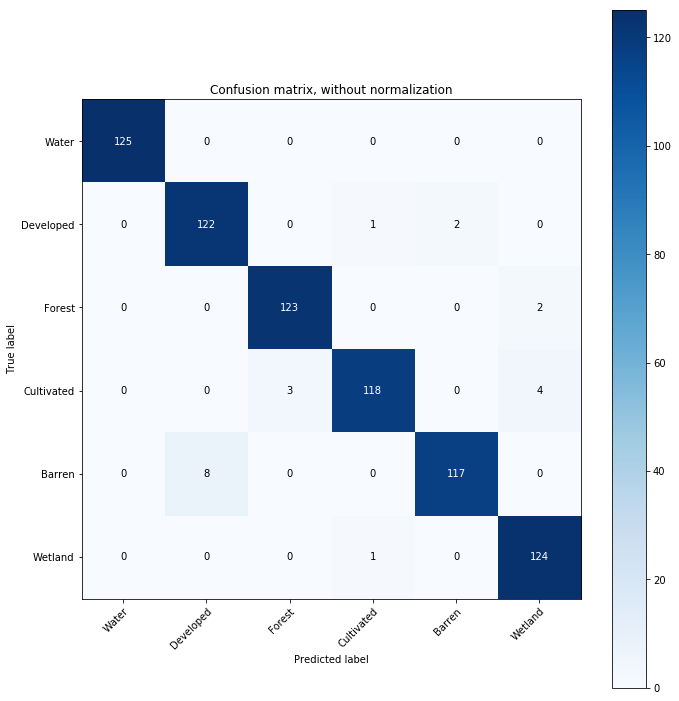

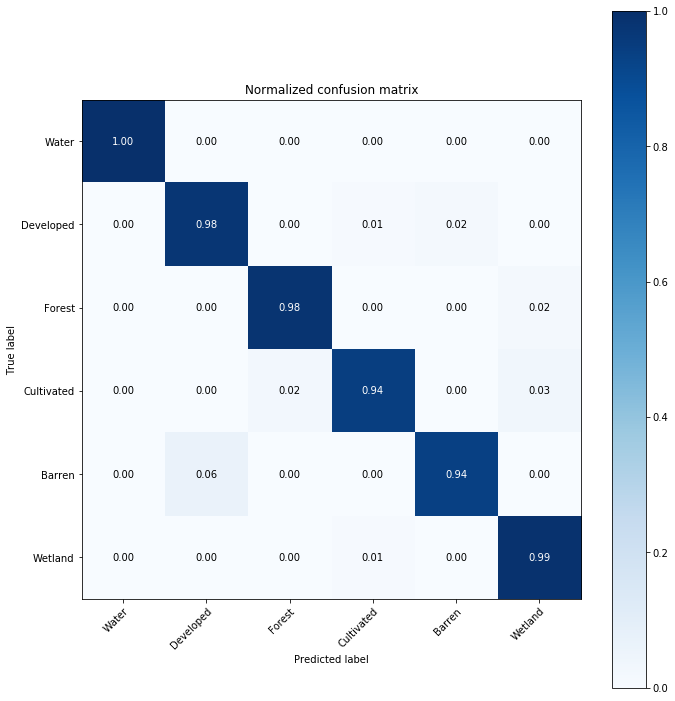

In [22]:
# Plot non-normalized confusion matrix
_, users_acc, prod_acc = util.plot_confusion_matrix(val_lc_lab.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)), class_dict=class_dict)
experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix")

# Plot normalized confusion matrix
util.plot_confusion_matrix(val_lc_lab.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)), class_dict=class_dict, normalize=True)
experiment.log_figure(figure=plt, figure_name="norm_conf_matrix")

count = 0
for i in range(len(val_lc_lab)):
    if(val_lc_lab[i] == pred_index[i]):
        count+=1

val_accuracy=count/len(val_lc_lab)
class_acc_dict = {}
print("Accuracy is",val_accuracy)

Calculate the accuracy per class
Calculate overall accuracy
Add training samples
add epochs
add tile size

In [23]:
experiment_df = pd.DataFrame(columns=['exp_name','model_name','time_steps','train_count','overall_acc', 
                                      'epochs', 'tile_size', 'training_time', 'inference_time',
                                      'water_acc_prod','dev_acc_prod', 'forest_acc_prod', 'cult_acc_prod', 'barren_acc_prod', 'wetland_acc_prod',
                                      'water_acc_user','dev_acc_user', 'forest_acc_user', 'cult_acc_user', 'barren_acc_user', 'wetland_acc_user'])   

In [24]:
experiment_df.loc[len(experiment_df)] = [exp_name, model_name, len(tiles['028012']), len(train_px)/class_count, val_accuracy, 
                                         epochs, tile_size, training_time, inference_time] + list(np.round(prod_acc,3)) + list(np.round(users_acc,3))


In [25]:
experiment_df.tail(5)

,exp_name,model_name,time_steps,train_count,overall_acc,epochs,tile_size,training_time,inference_time,water_acc_prod,...,forest_acc_prod,cult_acc_prod,barren_acc_prod,wetland_acc_prod,water_acc_user,dev_acc_user,forest_acc_user,cult_acc_user,barren_acc_user,wetland_acc_user
0,quick_view_all_onestep,all_sklearn,5,1500.0,0.972,0,13,00:04:44.043562,00:00:00.156127,1.0,...,0.984,0.944,0.936,0.992,1.0,0.938,0.976,0.983,0.983,0.954


In [26]:
experiment_df.to_csv('model_search/' + model_name + '--' + exp_name + '.csv')

In [27]:
all_exps = pd.read_csv('model_search/' + 'all_model_runs.csv')
all_exps = pd.concat([all_exps,experiment_df], ignore_index=True)
all_exps.to_csv('model_search/' + 'all_model_runs.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [28]:
params = {
    "exp_name":exp_name,
    "model_name":model_name,
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [29]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clifgray/chronos/a2997fff4fba4a33bae60f97c7cc53ea
COMET INFO:   Parameters [count]:
COMET INFO:     algorithm                : auto
COMET INFO:     bootstrap                : True
COMET INFO:     class_dict               : {0: 'Water', 1: 'Developed', 2: 'Forest', 3: 'Cultivated', 4: 'Barren', 5: 'Wetland'}
COMET INFO:     class_weight             : 1
COMET INFO:     cnn_tile_size            : 13
COMET INFO:     criterion                : gini
COMET INFO:     exp_name                 : quick_view_all_onestep
COMET INFO:     landsat_tiles            : {'028011': ['20110103', '20110308', '20110831', '20111018', '20111103'], '029011': ['20110103', '20110308', '20110730', '20110831', '20111018'], '028012': ['20110103', '20110308', '20110730', '2011083

In [30]:
import joblib
# now you can save it to a file
joblib.dump(clf, 'clf.pkl') 
# and later you can load it
#clf = joblib.load('filename.pkl')

['clf.pkl']